In [ ]:
# Upload your kaggle.json file
from google.colab import files
files.upload()  # Select your kaggle.json file when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vedduu","key":"33b73bbdc8cd3994ec6cd36beb2d8a20"}'}

In [ ]:
# Configure Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle competitions download -c house-prices-advanced-regression-techniques
!unzip house-prices-advanced-regression-techniques.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 769MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# Install XGBoost for advanced modeling
!pip install xgboost

✅ All libraries imported successfully!
Training data shape: (1460, 81)
Test data shape: (1459, 80)

First few rows of training data:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm

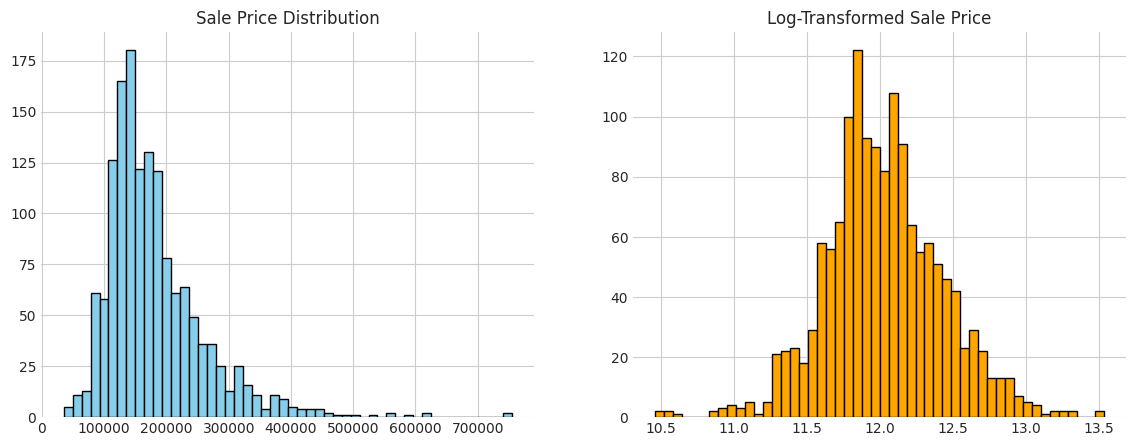


🔍 Missing Values Analysis:
              Missing_Count  Percentage
PoolQC                 1453   99.520548
MiscFeature            1406   96.301370
Alley                  1369   93.767123
Fence                  1179   80.753425
MasVnrType              872   59.726027
FireplaceQu             690   47.260274
LotFrontage             259   17.739726
GarageType               81    5.547945
GarageYrBlt              81    5.547945
GarageFinish             81    5.547945

📈 Top Correlated Features:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


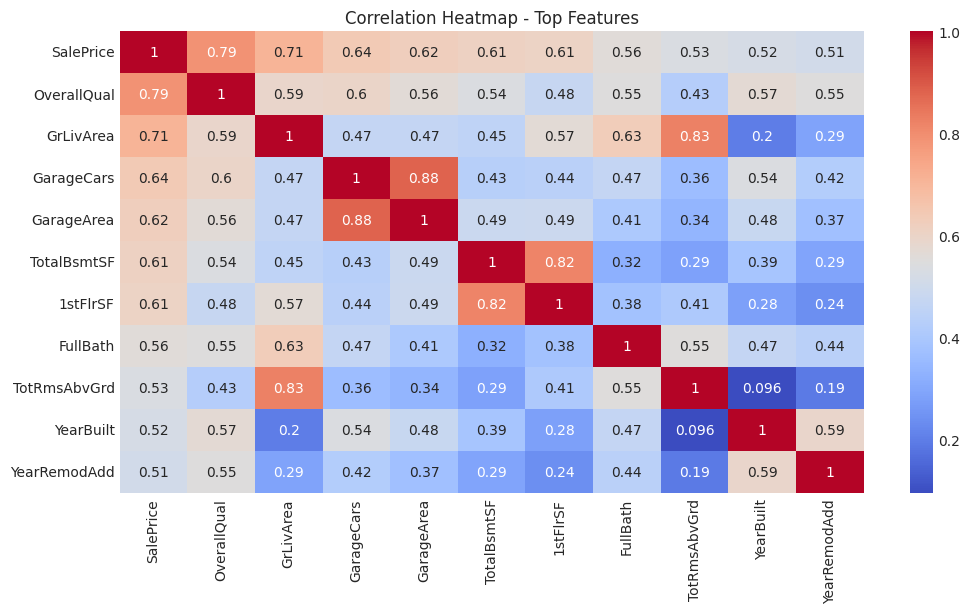


DATA PREPROCESSING

🔧 Handling Missing Values...
Remaining missing values: 0

⚙️ Feature Engineering...

🔤 Encoding Categorical Variables...
Final feature count: 239

📐 Fixing Skewness...
✅ Preprocessing complete!

MODEL TRAINING & EVALUATION
Linear Regression: RMSE=0.1214, R²=0.9051
Ridge: RMSE=0.1128, R²=0.9183
Lasso: RMSE=0.1129, R²=0.9181
ElasticNet: RMSE=0.1130, R²=0.9181
Random Forest: RMSE=0.1355, R²=0.8817
Gradient Boosting: RMSE=0.1235, R²=0.9018
XGBoost: RMSE=0.1187, R²=0.9092

📊 Model Performance Summary:
                       RMSE        R2
Ridge              0.112845  0.918251
Lasso              0.112914  0.918115
ElasticNet         0.112951  0.918067
XGBoost            0.118719  0.909184
Linear Regression  0.121444  0.905071
Gradient Boosting  0.123498  0.901828
Random Forest      0.135534  0.881721

🏆 Best Model: Ridge

💾 Submission file saved as 'submission.csv'

✅ Project complete!


In [ ]:
"""
House Price Prediction - Complete ML Pipeline
===============================================
Author: Vedant Patel
Dataset: Kaggle House Prices - Advanced Regression Techniques
Objective: Predict house sale prices using 79 explanatory variables.

This script demonstrates:
- Comprehensive EDA
- Feature engineering & selection
- Multiple regression model comparison
- Production-ready prediction pipeline
"""

# ==========================================
# 1. IMPORT LIBRARIES
# ==========================================

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("✅ All libraries imported successfully!")

# ==========================================
# 2. LOAD AND INSPECT DATA
# ==========================================

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_ids = test_df["Id"]

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nFirst few rows of training data:")
print(train_df.head())

# Quick overview
print("\nData Info:")
print(f"Total features: {train_df.shape[1] - 1}")
print(f"Numerical features: {train_df.select_dtypes(include=[np.number]).shape[1] - 2}")
print(f"Categorical features: {train_df.select_dtypes(include=['object']).shape[1]}")

# ==========================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================

print("\n" + "=" * 50)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# --- Target Variable ---
print("\n📊 Analyzing Target Variable: SalePrice")
print(train_df["SalePrice"].describe().apply(lambda x: f"${x:,.2f}"))
print(f"Skewness: {train_df['SalePrice'].skew():.3f}")
print(f"Kurtosis: {train_df['SalePrice'].kurtosis():.3f}")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(train_df["SalePrice"], bins=50, color="skyblue", edgecolor="black")
axes[0].set_title("Sale Price Distribution")
axes[1].hist(np.log1p(train_df["SalePrice"]), bins=50, color="orange", edgecolor="black")
axes[1].set_title("Log-Transformed Sale Price")
plt.show()

# --- Missing Values ---
print("\n🔍 Missing Values Analysis:")
missing = train_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if not missing.empty:
    missing_df = pd.DataFrame({
        "Missing_Count": missing,
        "Percentage": (missing / len(train_df)) * 100
    })
    print(missing_df.head(10))
else:
    print("No missing values found!")

# --- Correlations ---
print("\n📈 Top Correlated Features:")
corr = train_df.select_dtypes(include=[np.number]).corr()["SalePrice"].sort_values(ascending=False)
print(corr.head(10))
top_features = corr.head(11).index
sns.heatmap(train_df[top_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap - Top Features")
plt.show()

# ==========================================
# 4. DATA PREPROCESSING
# ==========================================

print("\n" + "=" * 50)
print("DATA PREPROCESSING")
print("=" * 50)

# --- Combine Train & Test ---
y_train = train_df["SalePrice"]
train_df.drop(["Id", "SalePrice"], axis=1, inplace=True)
test_df.drop(["Id"], axis=1, inplace=True)
all_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# --- Missing Values ---
print("\n🔧 Handling Missing Values...")
none_cols = [
    "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
    "GarageType", "GarageFinish", "GarageQual", "GarageCond",
    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "MasVnrType"
]
for col in none_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna("None")

zero_cols = [
    "GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath", "MasVnrArea"
]
for col in zero_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

mode_cols = ["MSZoning", "Electrical", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType", "Functional"]
for col in mode_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

if "LotFrontage" in all_data.columns:
    all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

if "Utilities" in all_data.columns:
    all_data.drop("Utilities", axis=1, inplace=True)

print(f"Remaining missing values: {all_data.isnull().sum().sum()}")

# --- Feature Engineering ---
print("\n⚙️ Feature Engineering...")

all_data["TotalSF"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"]
all_data["TotalBath"] = (
    all_data["FullBath"] + 0.5 * all_data["HalfBath"] +
    all_data["BsmtFullBath"] + 0.5 * all_data["BsmtHalfBath"]
)
all_data["TotalPorchSF"] = (
    all_data["OpenPorchSF"] + all_data["3SsnPorch"] +
    all_data["EnclosedPorch"] + all_data["ScreenPorch"] + all_data["WoodDeckSF"]
)
all_data["HouseAge"] = all_data["YrSold"] - all_data["YearBuilt"]
all_data["RemodAge"] = all_data["YrSold"] - all_data["YearRemodAdd"]

for col in ["PoolArea", "2ndFlrSF", "GarageArea", "TotalBsmtSF", "Fireplaces"]:
    flag = f"Has{col}"
    all_data[flag] = (all_data[col] > 0).astype(int)

all_data["OverallQual_GrLivArea"] = all_data["OverallQual"] * all_data["GrLivArea"]
all_data["OverallQual_TotalSF"] = all_data["OverallQual"] * all_data["TotalSF"]

# --- Outlier Removal ---
outlier_idx = all_data[(all_data["GrLivArea"] > 4000) & (all_data.index < len(y_train))].index
all_data.drop(outlier_idx, inplace=True)
y_train.drop(outlier_idx, inplace=True)

# --- Encoding ---
print("\n🔤 Encoding Categorical Variables...")
quality_map = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
ordinal_cols = [
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC",
    "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"
]
for col in ordinal_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].map(quality_map)

all_data = pd.get_dummies(all_data, drop_first=True)
print(f"Final feature count: {all_data.shape[1]}")

# --- Fix Skewness ---
print("\n📐 Fixing Skewness...")
y_train_log = np.log1p(y_train)
skewed = all_data.select_dtypes(include=[np.number]).apply(lambda x: skew(x.dropna()))
skewed = skewed[abs(skewed) > 0.75]
for col in skewed.index:
    all_data[col] = np.log1p(all_data[col])

# --- Split Data ---
X_train = all_data.iloc[: len(y_train)]
X_test = all_data.iloc[len(y_train):]
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
print("✅ Preprocessing complete!")

# ==========================================
# 5. MODEL TRAINING & EVALUATION
# ==========================================

def evaluate_model(model, X, y, name):
    """Evaluate model with 5-fold cross-validation."""
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfold))
    r2 = cross_val_score(model, X, y, scoring="r2", cv=kfold)
    print(f"{name}: RMSE={rmse.mean():.4f}, R²={r2.mean():.4f}")
    return rmse.mean(), r2.mean()

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=10.0, random_state=42),
    "Lasso": Lasso(alpha=0.0005, random_state=42, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=10000),
    "Random Forest": RandomForestRegressor(
        n_estimators=300, max_depth=15, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42
    ),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=3, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1
    )
}

print("\n" + "=" * 50)
print("MODEL TRAINING & EVALUATION")
print("=" * 50)

results = {}
for name, model in models.items():
    rmse, r2 = evaluate_model(model, X_train_scaled, y_train_log, name)
    results[name] = {"RMSE": rmse, "R2": r2}

results_df = pd.DataFrame(results).T.sort_values("RMSE")
print("\n📊 Model Performance Summary:")
print(results_df)

# ==========================================
# 6. FINAL MODEL & PREDICTIONS
# ==========================================

best_model_name = results_df.index[0]
print(f"\n🏆 Best Model: {best_model_name}")
final_model = models[best_model_name]
final_model.fit(X_train_scaled, y_train_log)

preds = np.expm1(final_model.predict(X_test_scaled))
submission = pd.DataFrame({"Id": test_ids, "SalePrice": preds})
submission.to_csv("submission.csv", index=False)
print("\n💾 Submission file saved as 'submission.csv'")

# ==========================================
# 7. FEATURE IMPORTANCE (for tree models)
# ==========================================

if hasattr(final_model, "feature_importances_"):
    fi = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": final_model.feature_importances_
    }).sort_values("Importance", ascending=False)
    sns.barplot(data=fi.head(20), x="Importance", y="Feature", palette="viridis")
    plt.title(f"Top 20 Important Features - {best_model_name}")
    plt.show()

print("\n✅ Project complete!")
